## Análisis exploratorio de los Datos 

In [88]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
import os 
import matplotlib.pyplot as plt
import pandas as pd

### 1. Estructura y forma de los datos

Comprobar las dimensiones de los arrays: print(X.shape)  # (n_videos, n_frames, 66)

Verificar si todos los vídeos tienen el mismo número de frames (o si hubo mucho padding).

Confirmar que todos los landmarks están en el mismo orden y escala.

In [ ]:
PATH = "../Data/Processed"

# Cargamos los datos
# Contienen etiquetas con los puntos clave del cuerpo durante las flexiones
# Los arrays tienen forma 
# num_keypoints -> 1er_punto_clave_x, 1er_punto_clave_y, 2º_punto_clave_x, 2º_punto_clave_y, ...

correct_push_ups = np.load(os.path.join(PATH, 'correct_push_ups_landmarks.npy'))
incorrect_push_ups = np.load(os.path.join(PATH, 'wrong_push_ups_landmarks.npy'))

print("Correct push-ups shape:", correct_push_ups.shape)     # (num_ejemplos, num_frames, num_keypoints)
print("Incorrect push-ups shape:", incorrect_push_ups.shape) # (num_ejemplos, num_frames, num_keypoints)

data = np.vstack((correct_push_ups, incorrect_push_ups))
# y = np.array([1]*correct_push_ups.shape[0] + [0]*incorrect_push_ups.shape[0])  

Correct push-ups shape: (50, 160, 66)
Incorrect push-ups shape: (50, 160, 66)


Vemos que ambos conjuntos de datos tienen el mismo número de videos, cada video tiene el mismo numero de frames y cada frame tiene el mismo número de landmarks.

In [25]:
video0 = correct_push_ups[0]  # primer video
#print(video0.shape)  # (160, 66)
#print(video0)        # imprime todos los frames y landmarks del video 0, cada fila indica los landmarks de un frame 

frame0_video0 = correct_push_ups[0, 0]  # primer frame del primer video
#print(frame0_video0.shape)  # (66,)
#print(frame0_video0)        # imprime los 66 landmarks de ese frame (coincide con la primera fila del print anterior)

landmark0_frame0_video0 = correct_push_ups[0, 0, 0]  # primer landmark
#print(landmark0_frame0_video0)  # valor del landmark 

Media de padding por secuencia: 37.63%
Máximo padding: 71.88%
Mínimo padding: 0.00%


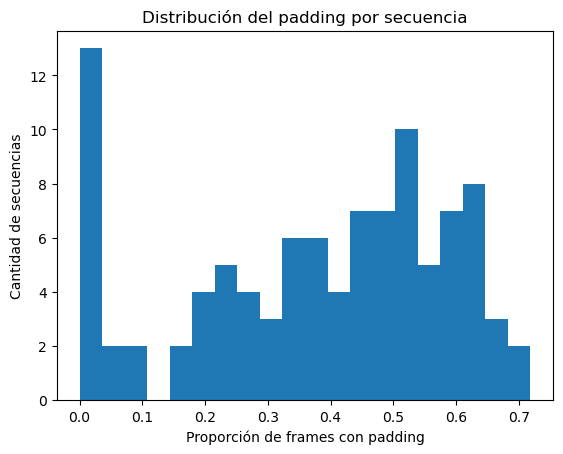

In [27]:
# Calculamos la proporción de frames vacíos (rellenos con ceros) por secuencia
padding_ratios = []

data = np.vstack((correct_push_ups, incorrect_push_ups))
for seq in data:
    # Un frame está vacío si todos sus landmarks son 0 
    empty_frames = np.sum(np.all(seq == 0, axis=1)) # suma cada fila que es todo 0
    ratio = empty_frames / seq.shape[0]
    padding_ratios.append(ratio)

# Estadísticas del padding
print(f"Media de padding por secuencia: {np.mean(padding_ratios):.2%}")
print(f"Máximo padding: {np.max(padding_ratios):.2%}")
print(f"Mínimo padding: {np.min(padding_ratios):.2%}")

# Distribución visual
plt.hist(padding_ratios, bins=20)
plt.xlabel("Proporción de frames con padding")
plt.ylabel("Cantidad de secuencias")
plt.title("Distribución del padding por secuencia")
plt.show()

El porcentaje obtenido es un poco alto, 37.63% pero esto se debe a que en los videos incorrectos, algunos (9 videos) superaban los 200 frames, llegando hasta los 400, por lo que esto incrementó el numero optimo de frames por video al calcular $L_{opt}$.

Vamos a comprobar si los landmarks están normalizados

In [38]:
longitudes_combinadas = np.vstack((correct_push_ups, incorrect_push_ups)).reshape(-1, correct_push_ups.shape[2]) 
# Con el -1 del reshape combinamos el número de videos y el número de frames, obteniendo una lista donde cada fila es un frame individual de cualquier video (100*160 numero de filas).
# 'correct_push_ups.shape[2]' lo que hace es mantener el número de landmarks (66) como el número de columnas, es decir, cada fila tiene los 66 landmarks de ese frame.

min_val = np.min(longitudes_combinadas)
max_val = np.max(longitudes_combinadas)

print(f"Valor mínimo de coordenadas: {min_val:.4f}")
print(f"Valor máximo de coordenadas: {max_val:.4f}")

Valor mínimo de coordenadas: -0.3072
Valor máximo de coordenadas: 1.1568


Vamos a normalizar los landmarks

In [42]:
rango = max_val - min_val

# Aplicamos la fórmula de Re-normalización
longitudes_combinadas_escaladas = (longitudes_combinadas - min_val) / rango

correct_push_ups_escaladas = (correct_push_ups - min_val) / rango
incorrect_push_ups_escaladas = (incorrect_push_ups - min_val) / rango

Vamos a comprobar ahora el orden de los landmarks. Esto lo haremos comparando las coordenadas de los landmarks de diferentes videos en un mismo frame.

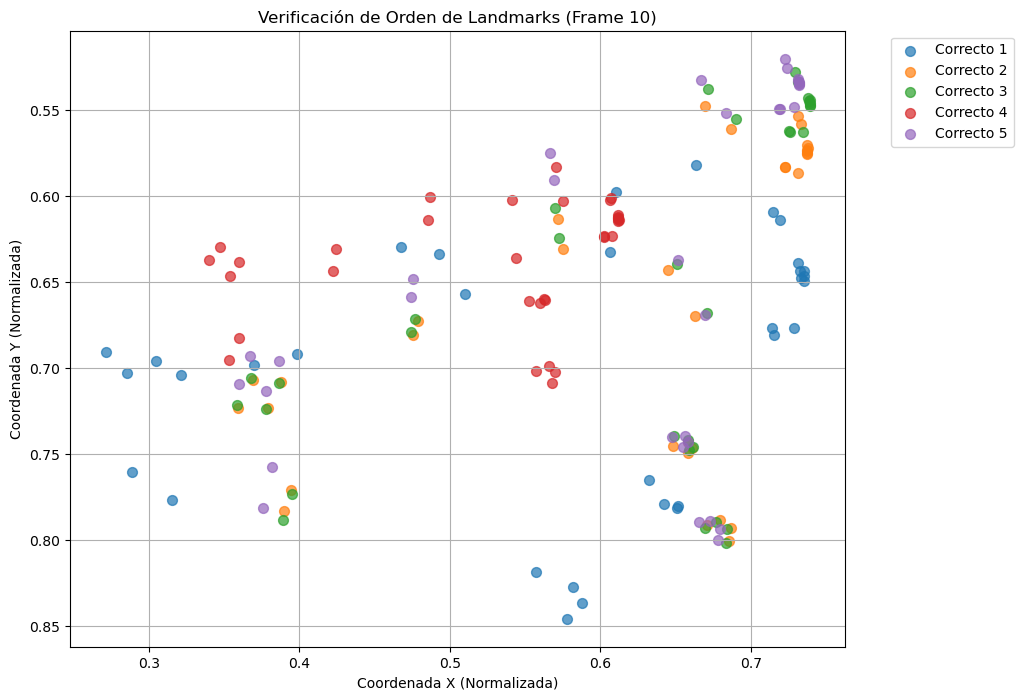

In [ ]:
# Usamos las variables escaladas 
data_correctas = correct_push_ups_escaladas
data_incorrectas = incorrect_push_ups_escaladas

# Parámetros 
FRAME_DE_MUESTRA = 10  # Frame representativo
NUM_VIDEOS_A_GRAFICAR = 5 # Graficamos los primeros 5 videos de cada clase

# Recogemos una muestra de los videos para la visualización
videos_a_comparar = [] # esta lista contendrá diccionarios con 'data' que es el array del video, de la forma --> (frames, landmarks) = (160, 66); y 'label' que es la etiqueta de clase

# Tomamos la muestra de correctos y añadimos una etiqueta de clase
for i in range(NUM_VIDEOS_A_GRAFICAR):
    videos_a_comparar.append({'data': correct_push_ups_escaladas[i], 'label': f'Correcto {i+1}'}) 

# Tomamos la muestra de incorrectos y añadimos una etiqueta de clase
#for i in range(NUM_VIDEOS_A_GRAFICAR):
    #videos_a_comparar.append({'data': incorrect_push_ups_escaladas[i], 'label': f'Incorrecto {i+1}'})
# Generamos el Gráfico 
plt.figure(figsize=(10, 8))
plt.title(f'Verificación de Orden de Landmarks (Frame {FRAME_DE_MUESTRA})')
plt.xlabel('Coordenada X (Normalizada)')
plt.ylabel('Coordenada Y (Normalizada)')
plt.gca().invert_yaxis() # Es estándar invertir el eje Y en datos de visión

# Iteramos y graficamos el frame de cada video
for video_info in videos_a_comparar:
    video_data = video_info['data'] # selecciona el video (de la forma (160, 66))
    label = video_info['label'] # etiqueta del video
    
    try:
        frame_data = video_data[FRAME_DE_MUESTRA, :].reshape(-1, 2) # seleccionamos un frame concreto (66 landmarks) y dividimos esos 66 puntos en pares de 2: [[X0, Y0], [X1, Y1], ..., [X32, Y32]]^T
        
        # Graficar todos los landmarks del frame
        plt.scatter(frame_data[:, 0], frame_data[:, 1], # las dos columnas representan las coordenadas X e Y
                    label=label, # asignamos la etiqueta del video (correcto/incorrecto + número)
                    alpha=0.7, s=50) # nivel de transparencia y tamaño de los puntos
        
    except IndexError:
        print(f"Advertencia: {label} es más corto que el Frame {FRAME_DE_MUESTRA}.") # En caso de que el numero de videos supere el frame seleccionado

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

Podemos ver que en el caso de los videos correctos (los unicos que hemos seleccionado), los landmarks se agrupan pr zonas mas o menos diferenciadas, lo cual es indicativo de que los landmarks están ordenados. Es un poco complicado diferenciar las partes del cuerpo, por lo que vamos a ver la distribución espacial de los landmarks uniendo los puntos para poder visualizar la pose promedio de cada clase.

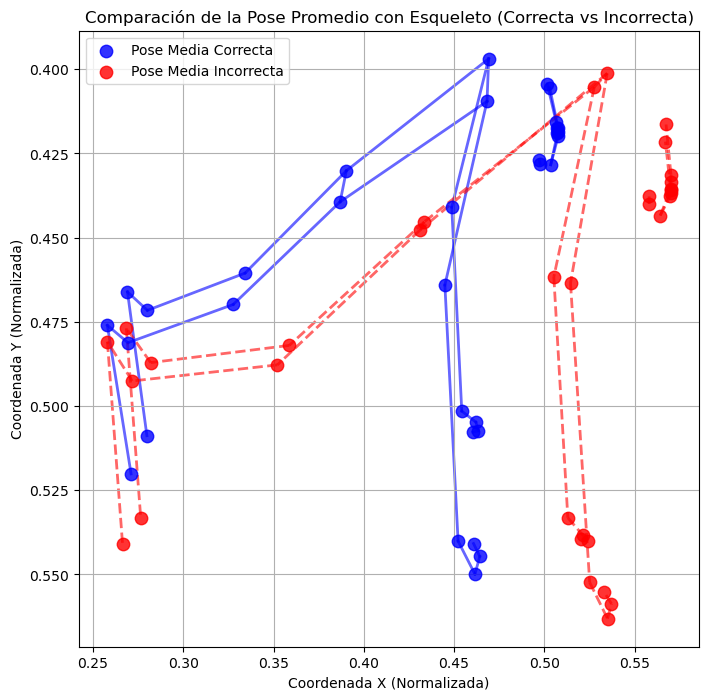

In [ ]:
# Definimos las conexiones del esqueleto (pares de índices de landmarks) 
# Esto es específico para un modelo de 33 landmarks (como MediaPipe Pose), cada tupla (start_idx, end_idx) conecta dos landmarks.
# Si buscamos información sobre las conexiones de MediaPipe Pose: https://ai.google.dev/edge/mediapipe/solutions/vision/pose_landmarker?hl=es-419#models, vemos que cada punto corresponde a la siguiente parte del cuerpo:
CONNECTIONS = [
    # Cabeza
    (0, 1), (1, 2), (2, 3), (3, 7), 
    (0, 4), (4, 5), (5, 6), (6, 8),
    (9, 10), 

    # Torso y Hombros
    (11, 12),  # Hombros
    (11, 23),  # Hombro Izquierdo a Cadera Izquierda
    (12, 24),  # Hombro Derecho a Cadera Derecha
    (23, 24),  # Caderas

    # Brazo Izquierdo
    (11, 13), (13, 15), 
    # Mano Izquierda
    (15, 17), (15, 19), (15, 21), 

    # Brazo Derecho
    (12, 14), (14, 16), 
    # Mano Derecha
    (16, 18), (16, 20), (16, 22), 

    # Pierna Izquierda
    (23, 25), (25, 27), 
    # Pie Izquierdo
    (27, 29), (29, 31), 

    # Pierna Derecha
    (24, 26), (26, 28), 
    # Pie Derecho
    (28, 30), (30, 32) 
]

# Preparación y cálculo de la media (versiones escaladas)
data_correctas = correct_push_ups_escaladas
data_incorrectas = incorrect_push_ups_escaladas

# Aplanamos los datos para obtener todos los frames juntos 
frames_correctos_aplanados = data_correctas.reshape(-1, data_correctas.shape[-1]) # (50*160, 66) 
frames_incorrectos_aplanados = data_incorrectas.reshape(-1, data_incorrectas.shape[-1]) # (50*160, 66)

# Calculamos el promedio de cada columna (landmark) a lo largo de todos los frames de cada clase (la pose promedio de cada clase) y dividimos el vector de 66 valores en pares (X, Y) 
pose_media_correcta = np.mean(frames_correctos_aplanados, axis=0).reshape(-1, 2) # tiene la forma [[X0, Y0], [X1, Y1], ..., [X32, Y32]]^T
pose_media_incorrecta = np.mean(frames_incorrectos_aplanados, axis=0).reshape(-1, 2)


# Gráfico de comparación con conexiones 
plt.figure(figsize=(8, 8))
plt.title('Comparación de la Pose Promedio con Esqueleto (Correcta vs Incorrecta)')
plt.xlabel('Coordenada X (Normalizada)')
plt.ylabel('Coordenada Y (Normalizada)')
plt.gca().invert_yaxis() # Y==0 es la parte superior

# Dibujamos la pose promedio correcta (Azul)
plt.scatter(pose_media_correcta[:, 0], pose_media_correcta[:, 1], 
            label='Pose Media Correcta', 
            color='blue', 
            alpha=0.8, s=80, zorder=2)
# Conectamos los puntos correctos
for connection in CONNECTIONS:
    start_point = pose_media_correcta[connection[0]]
    end_point = pose_media_correcta[connection[1]]
    plt.plot([start_point[0], end_point[0]], 
             [start_point[1], end_point[1]], 
             color='blue', linestyle='-', linewidth=2, alpha=0.6, zorder=1)


# Dibujamos la pose promedio incorrecta (Rojo)
plt.scatter(pose_media_incorrecta[:, 0], pose_media_incorrecta[:, 1], 
            label='Pose Media Incorrecta', 
            color='red', alpha=0.8, s=80, zorder=2)
# Conectamos los puntos incorrectos
for connection in CONNECTIONS:
    start_point = pose_media_incorrecta[connection[0]]
    end_point = pose_media_incorrecta[connection[1]]
    plt.plot([start_point[0], end_point[0]], 
             [start_point[1], end_point[1]], 
             color='red', linestyle='--', linewidth=2, alpha=0.6, zorder=1) # Líneas discontinuas para diferenciar

plt.legend()
plt.grid(True)
plt.show()

Se aprecian perfectamente las partes del cuerpo en ambas clases y se ve cómo en la clase de flexiones incorrectas, la cadera esta más abajo de lo normal.

Esto también nos sirve para demostrar que los landmarks son coherentes, es decir, no saltan de un frame a otro.

### 4. Aspecto temporal. 

Analizar cómo varían ciertos puntos clave con el tiempo:
→ trayectoria del hombro, codo o rodilla.
→ comparación entre un push-up correcto e incorrecto.

Ejemplo:

plt.plot(X[i,:,mp_pose.PoseLandmark.RIGHT_SHOULDER.value*2])  # eje X del hombro


Contar cuántas repeticiones hay por vídeo (picos o ciclos de movimiento).


### 8. Estadísticas descriptivas

Media, desviación estándar y rango por landmark (x, y).

Comparar entre clases: ¿la media de la posición del pecho o codo difiere entre clases?

In [ ]:
# Definimos los nombres de los landmarks 
LANDMARK_NAMES = [
    'nose', 'left eye (inner)', 'left eye', 'left eye (outer)', 'right eye (inner)', 'right eye', 'right eye (outer)', 
    'left ear', 'right ear', 'mouth (left)', 'mouth (right)', 'left shoulder', 'right shoulder', 'left elbow', 
    'right elbow', 'left wrist', 'right wrist', 'left pinky', 'right pinky', 'left index', 'right index', 
    'left thumb', 'right thumb', 'left hip', 'right hip', 'left knee', 'right knee', 'left ankle', 
    'right ankle', 'left heel', 'right heel', 'left foot index', 'right foot index'
]

# Creamos una lista de 66 nombres: 'nose (X)', 'nose (Y)', 'left eye (inner) (X)', 'left eye (inner) (Y)', ...
COORD_NAMES = [f'{name} ({coord})' for name in LANDMARK_NAMES for coord in ['X', 'Y']]
NUM_COORDS = len(COORD_NAMES) # 66

# Combinamos y aplanamos los datos escalados para que cada fila sea un frame único.
frames_correctos_aplanados = correct_push_ups_escaladas.reshape(-1, NUM_COORDS) # (num_frames_correctos, 66)
frames_incorrectos_aplanados = incorrect_push_ups_escaladas.reshape(-1, NUM_COORDS)

# Combinamos todos los frames en un solo array grande para el cálculo global.
longitudes_combinadas_escaladas = np.vstack((frames_correctos_aplanados, frames_incorrectos_aplanados)) # (16000, 66)

# Calculamos las estadísticas a lo largo del eje 0 (todos los frames)
media = np.mean(longitudes_combinadas_escaladas, axis=0)
desviacion_estandar = np.std(longitudes_combinadas_escaladas, axis=0)
maximo = np.max(longitudes_combinadas_escaladas, axis=0)
minimo = np.min(longitudes_combinadas_escaladas, axis=0)
rango = maximo - minimo

# Visualización del DataFrame de resultados 
df_resultados = pd.DataFrame({
    'Coordenada': COORD_NAMES,
    'Media (μ)': media,
    'Desviación Estándar (σ)': desviacion_estandar,
    'Máximo': maximo,
    'Mínimo': minimo,
    'Rango (Max - Min)': rango
})

# Mostramos los resultados
print("Estadísticas Descriptivas por Landmark:\n")
print(df_resultados.to_markdown(index=False, numalign="left", stralign="left")) # Hacemos que la tabla se vea bien en la terminal

Estadísticas Descriptivas por Landmark:

| Coordenada            | Media (μ)   | Desviación Estándar (σ)   | Máximo   | Mínimo      | Rango (Max - Min)   |
|:----------------------|:------------|:--------------------------|:---------|:------------|:--------------------|
| nose (X)              | 0.533876    | 0.254648                  | 0.865437 | 0.209855    | 0.655581            |
| nose (Y)              | 0.435909    | 0.194246                  | 0.841001 | 0.209855    | 0.631146            |
| left eye (inner) (X)  | 0.538809    | 0.258286                  | 0.867372 | 0.209855    | 0.657516            |
| left eye (inner) (Y)  | 0.428653    | 0.189651                  | 0.839148 | 0.209855    | 0.629292            |
| left eye (X)          | 0.538814    | 0.258267                  | 0.866664 | 0.209855    | 0.656808            |
| left eye (Y)          | 0.427639    | 0.188872                  | 0.837506 | 0.209855    | 0.62765             |
| left eye (outer) (X)  | 0.53881     |

Con estos resultados podemos ver la ubicacion media de diversas partes del cuerpo, por ejemplo la nariz esta a una altura de 0.533876 del eje X, mientras que el pie derecho está a una altura de 0.268688 respecto al eje X. Las desviaciones nos sirven para ver cuanto varía la posición del landmark respecto a su media, y como podemos observar, obtenemos valores normales teniendo en cuenta que el movimiento es una flexión. Si nos vamos a partes más fijas a lo largo de una flexión, como pueden ser los pies que permanecen inmoviles, obtenemos desviaciones mucho más bajas en el eje X, como 0.0780976 en el pie izquierdo y 0.0738948 en el derecho.

### Reducción de dimensionalidad

Aplicar PCA o t-SNE sobre los vectores medios de cada vídeo → ver si las clases se separan visualmente.

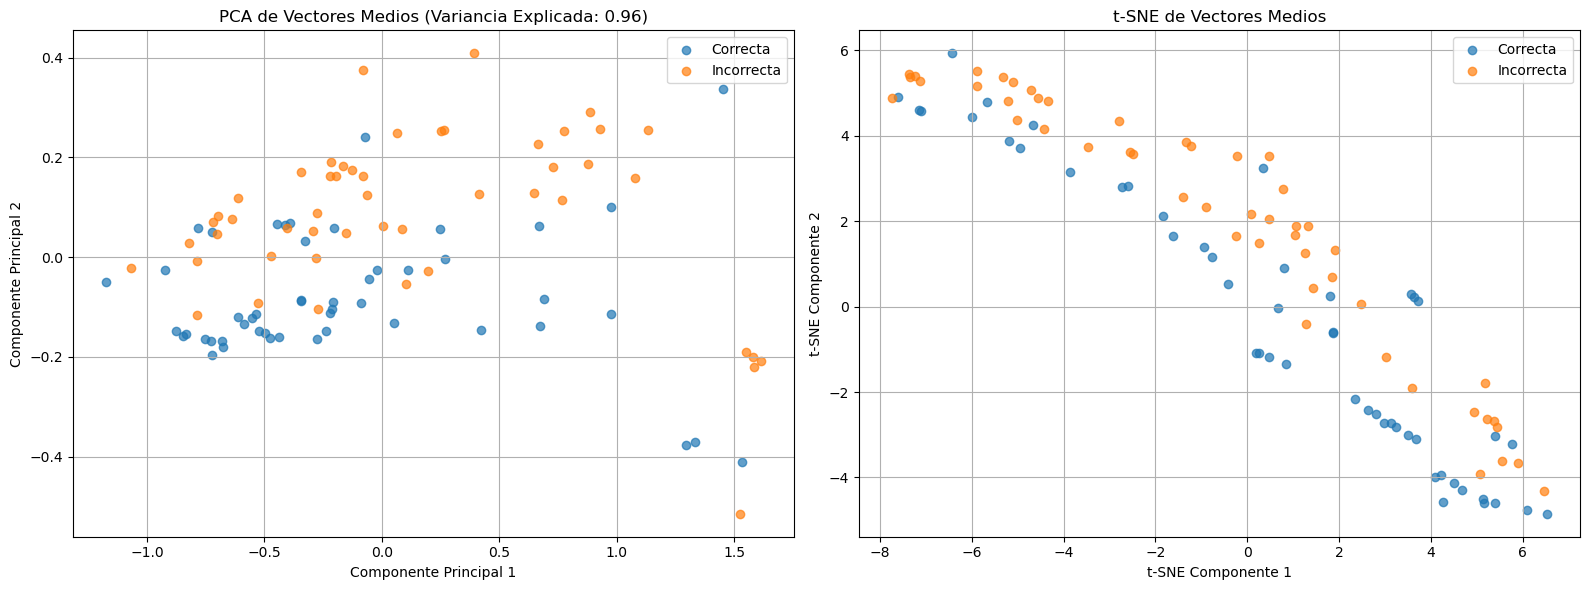

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Calculamos el vector medio (pose promedio) por vídeo 
mean_vectors_correct = np.mean(correct_push_ups_escaladas, axis=1) # Media a lo largo del eje 1 (frames). Esto reduce la forma (Videos, Frames, Coordenadas) a (Videos, Coordenadas)
mean_vectors_incorrect = np.mean(incorrect_push_ups_escaladas, axis=1)

# Combinamos los vectores medios en una sola matriz (X_mean) y creamos etiquetas (y)
X_mean = np.vstack((mean_vectors_correct, mean_vectors_incorrect))
y = np.array(['Correcta'] * mean_vectors_correct.shape[0] + ['Incorrecta'] * mean_vectors_incorrect.shape[0])

# Aplicamos PCA 
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_mean)
explained_variance = pca.explained_variance_ratio_.sum()

# Aplicamos t-SNE 
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto') 
X_tsne = tsne.fit_transform(X_mean)

# Generamos gráficos
plt.figure(figsize=(16, 6))

# Subplot 1: PCA
plt.subplot(1, 2, 1)
for label in np.unique(y):
    subset = X_pca[y == label]
    plt.scatter(subset[:, 0], subset[:, 1], label=label, alpha=0.7)

plt.title(f'PCA de Vectores Medios (Variancia Explicada: {explained_variance:.2f})')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)

# Subplot 2: t-SNE
plt.subplot(1, 2, 2)
for label in np.unique(y):
    subset = X_tsne[y == label]
    plt.scatter(subset[:, 0], subset[:, 1], label=label, alpha=0.7)

plt.title('t-SNE de Vectores Medios')
plt.xlabel('t-SNE Componente 1')
plt.ylabel('t-SNE Componente 2')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('visualizacion_separacion_clases.png')
plt.show()

En el PCA, a pesar de que ambos conjuntos no estén completamente separados, se mezclan en el centro, podemos ver cómo los puntos naranjas (flexiones incorrectas) se agrupan en la parte superior derecha (valores más altos), mmientras que los puntos que hacen referencia a las flexiones bien hechas, se agrupan en la parte media-inferior izquierda (valores más bajos) 

El gráfico de t-SNE confirma la separación encontrada por PCA. t-SNE muestra una clara estructura lineal donde los puntos de una clase siguen una línea que está por encima o por debajo de los puntos de la otra clase, con una separación mínima. La mayoría de los puntos incorrectos (naranja) están desplazados ligeramente por encima y a la izquierda de los puntos correctos (azul). Esto sugiere que la diferencia entre las clases es ciertamente consistente.  
Concluyendo, mediante t-SNE observamos que en el espacio de alta dimensión (los 66 landmarks), los videos de una clase están íntimamente relacionados entre sí, y que la distancia entre un video correcto y un video incorrecto es grande.

### Augmentación de datos 
Haciendo transformaciones de los vídeos (por ejemplo, aplicarles un modo espejo y luego calculas los landmarks). Ya tienes funciones que calculan esos landmarks en el repositorio. El caso es completar el notebook de alguna forma para que quede mejor.